In [42]:
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]
#!pip install "gym[accept-rom-license, atari]"

# model = tf.keras.models.load_model(model_path)

In [43]:
import multiprocessing
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3 import DQN

import time
import numpy as np
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image

In [44]:
num_cpu = multiprocessing.cpu_count()
print("Number of CPUs:", num_cpu)

n_env = 1
print("Creating environment with {} processes".format(n_env))

# Create the environment with 4 stacked frames
env = make_atari_env("ALE/MsPacman-v5")
env = VecFrameStack(env, n_stack=4)
env = VecVideoRecorder(env, "./video/", record_video_trigger=lambda x: x == 0, video_length=400, name_prefix="dqn-agent")
env.metadata["render_fps"] = 1

Number of CPUs: 8
Creating environment with 1 processes


In [45]:
# load model
model_path = "./model/stable_model_10milion.zip"
model = DQN.load(model_path)

In [46]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

data = {i: [[]] for i in range(n_env)}
tmp_data = {i: 1 for i in range(n_env)}

obs = env.reset()

while True:
    actions, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(actions)
    
    for i in range(n_env):
        if tmp_data[i]-1 >= len(data[i]):
            data[i].append([])
        if rewards[i] is not None:  # Check if the reward is not None
            data[i][tmp_data[i]-1].append(rewards[i])
        if dones[i]:
            tmp_data[i] += 1

    # Render the environment and display the frame
    screen = env.render()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    time.sleep(1/8)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([tmp_data[i] > 3 for i in range(n_env)]):
        break

ipythondisplay.clear_output(wait=True)
env.close()

Moviepy - Building video /home/mister/Desktop/PacmanDQN/stable_DQN/video/dqn-agent-step-0-to-step-400.mp4.
Moviepy - Writing video /home/mister/Desktop/PacmanDQN/stable_DQN/video/dqn-agent-step-0-to-step-400.mp4



Moviepy - Done !
Moviepy - video ready /home/mister/Desktop/PacmanDQN/stable_DQN/video/dqn-agent-step-0-to-step-400.mp4


In [47]:
import copy
from pprint import pprint

copy_data = copy.deepcopy(data)

for i in range(n_env):
    for j in range(len(copy_data[i])):
        copy_data[i][j] = [np.sum(copy_data[i][j]), len(copy_data[i][j])]

pprint(copy_data)


{0: [[108.0, 173], [9.0, 45], [2.0, 33]]}


In [50]:
for i in range(n_env):
    print("Total episodes for CPU", i, ":", len(copy_data[i][0]))
    print("Total reward for CPU", i, ":", sum([copy_data[i][j][0] for j in range(len(copy_data[i]))]), "with average reward", format(sum([copy_data[i][j][0] for j in range(len(copy_data[i]))])/len(copy_data[i]), '.2f'))
    print("Total steps for CPU", i, ":", sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), "with average steps", format(sum([copy_data[i][j][1] for j in range(len(copy_data[i]))])/len(copy_data[i]), '.2f'))
    print("Weighted average reward for CPU", i, ":", format(sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(len(copy_data[i]))])/sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), '.2f'))
    print()

print("Total episodes:", sum([len(copy_data[i]) for i in range(n_env)]))

Total episodes for CPU 0 : 2
Total reward for CPU 0 : 119.0 with average reward 39.67
Total steps for CPU 0 : 251 with average steps 83.67
Weighted average reward for CPU 0 : 76.31

Total episodes: 3


In [51]:
data_file = "./data/raw_data_10milion.txt"

data_list = []
current_dict = {}

with open(data_file, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("|"):
            key, value = line.split("|")[1:-1]
            key = key.strip()
            if not key.endswith("/"):
                current_dict[key] = value.strip()
        elif line.startswith("-"):
            if current_dict:
                data_list.append(current_dict)
                current_dict = {}

print(data_list)

[{'exploration_rate': '0.999', 'episodes': '4', 'fps': '147', 'time_elapsed': '1', 'total_timesteps': '212'}, {'exploration_rate': '0.997', 'episodes': '8', 'fps': '194', 'time_elapsed': '1', 'total_timesteps': '380'}, {'ep_len_mean': '541', 'ep_rew_mean': '408', 'exploration_rate': '0.996', 'episodes': '12', 'fps': '219', 'time_elapsed': '2', 'total_timesteps': '580'}, {'ep_len_mean': '541', 'ep_rew_mean': '408', 'exploration_rate': '0.994', 'episodes': '16', 'fps': '240', 'time_elapsed': '3', 'total_timesteps': '796'}, {'ep_len_mean': '515', 'ep_rew_mean': '376', 'exploration_rate': '0.994', 'episodes': '20', 'fps': '246', 'time_elapsed': '3', 'total_timesteps': '912'}, {'ep_len_mean': '506', 'ep_rew_mean': '370', 'exploration_rate': '0.992', 'episodes': '24', 'fps': '257', 'time_elapsed': '4', 'total_timesteps': '1144'}, {'ep_len_mean': '542', 'ep_rew_mean': '422', 'exploration_rate': '0.991', 'episodes': '28', 'fps': '261', 'time_elapsed': '4', 'total_timesteps': '1276'}, {'ep_len_

In [53]:
from pprint import pprint
pprint(data_list[100])

{'ep_len_mean': '567',
 'ep_rew_mean': '526',
 'episodes': '404',
 'exploration_rate': '0.873',
 'fps': '248',
 'learning_rate': '0.00025',
 'loss': '21.1',
 'n_updates': '512',
 'time_elapsed': '73',
 'total_timesteps': '18200'}


In [78]:
import pandas as pd

df = pd.DataFrame(data_list)


# Convert columns to numeric
numeric_columns = ['ep_len_mean', 'ep_rew_mean', 'episodes', 'exploration_rate', 'fps', 'learning_rate', 'loss', 'n_updates', 'time_elapsed', 'total_timesteps']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

# Divide the 'episodes' by 3 = 1 game
df['games'] = df['episodes'] // 3

In [79]:
# Descriptive statistics
statistics = df.describe()

# Print statistics
print(statistics)

       exploration_rate       episodes          fps  time_elapsed  \
count      41795.000000   41795.000000  41795.00000  41795.000000   
mean           0.304665   83592.000000    153.80067  32317.461562   
std            0.046534   48261.286348     16.93131  22296.785479   
min            0.300000       4.000000    130.00000      1.000000   
25%            0.300000   41798.000000    142.00000  12354.000000   
50%            0.300000   83592.000000    152.00000  29612.000000   
75%            0.300000  125386.000000    163.00000  50292.500000   
max            0.999000  167180.000000    319.00000  76748.000000   

       total_timesteps   ep_len_mean   ep_rew_mean  learning_rate  \
count     4.179500e+04  41793.000000  41793.000000   4.173800e+04   
mean      4.651213e+06    739.443735   1180.695427   2.500000e-04   
std       2.924783e+06     92.482026    336.233190   1.084215e-19   
min       2.120000e+02    506.000000    370.000000   2.500000e-04   
25%       2.020780e+06    669.000

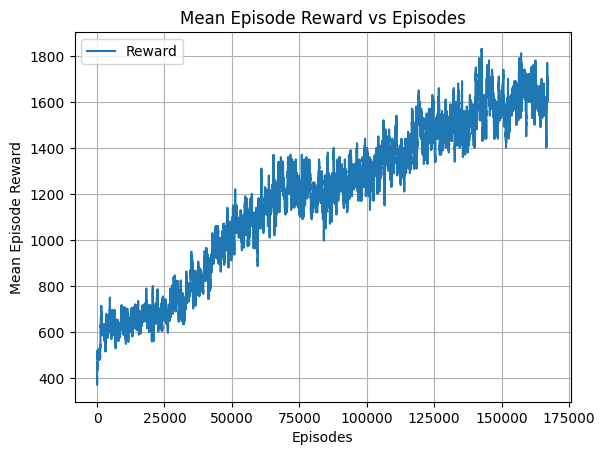

In [87]:
import matplotlib.pyplot as plt

# Line chart for 'episodes' vs 'ep_rew_mean'
plt.plot(df['episodes'], df['ep_rew_mean'], label='Reward')
plt.xlabel('Episodes')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Episode Reward vs Episodes')
plt.grid(True)
plt.legend()
plt.show()

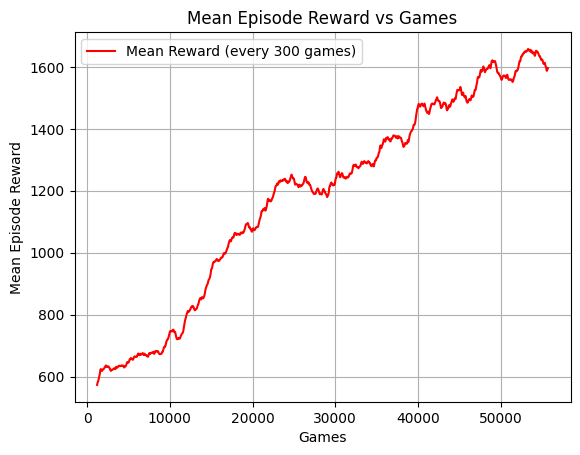

In [89]:
# Calculate rolling mean for every 10 episodes
rolling_mean = df['ep_rew_mean'].rolling(window=900).mean()

# Line chart for 'games' vs 'ep_rew_mean'
plt.plot(df['games'], rolling_mean, color='red', label='Mean Reward (every 300 games)')
plt.xlabel('Games')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Episode Reward vs Games')
plt.grid(True)
plt.legend()
plt.show()

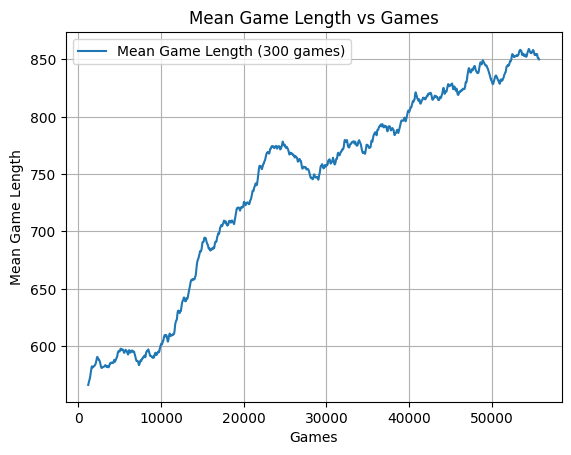

In [85]:
# Calculate rolling mean for every 10 episodes
game_len_mean = df['ep_len_mean'].rolling(window=900).mean()

# Line chart for 'episodes' vs 'ep_len_mean'
plt.plot(df['games'], game_len_mean, label='Mean Game Length (every 300 games)')
plt.xlabel('Games')
plt.ylabel('Mean Game Length')
plt.title('Mean Game Length vs Games')
plt.grid(True)
plt.legend()
plt.show()

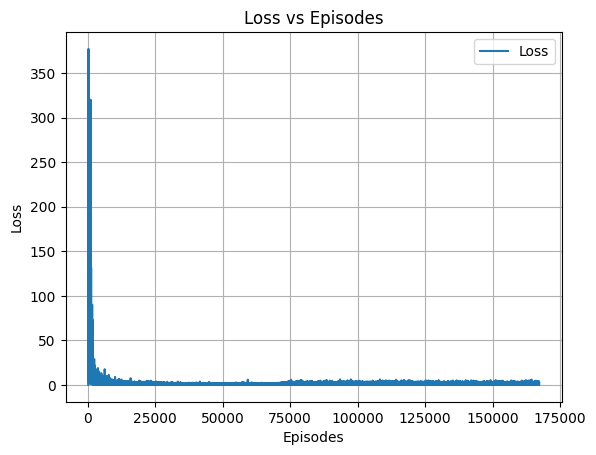

In [67]:
# Line chart for 'episodes' vs 'loss'
plt.plot(df['episodes'], df['loss'], label='Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Loss vs Episodes')
plt.legend()
plt.grid(True)
plt.show()